# Titanic: Machine Learning from Disaster

## Project Description:

This is a guided project to familiarize and practice data analytic process: <br>
- **Data exploration**: to find patterns in the data
- **Feature engineering**: to create new features from those patterns or through pure experimentation
- **Feature selection**: to select the best subset of our current set of features
- **Model selection/tuning**: training a number of models with different hyperparameters to find the best performer. <br> 

The data set is from [Kaggle](https://www.kaggle.com/c/titanic/data). 

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [29]:
def apply_functions(df):
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_titles(df)
    process_cabin(df)
    
    for col in ['Age_categories', 'Fare_categories','Title',
                'Cabin_type','Sex']:
        df = create_dummies(df, col)
    return df

train = apply_functions(train)
holdout = apply_functions(holdout)

## 1. Data Exploration

Let's explore the **SibSp** and **Parch** columns first:

In [30]:
explore_cols = ["SibSp","Parch"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


Using histograms to view the distribution of values in the columns

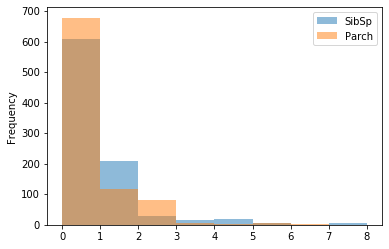

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.plot.hist(alpha=0.5, bins=8)

From the data dictionary of [Titanic Kaggle Competition](https://www.kaggle.com/c/titanic/data) we know: <br>
- **SibSp**: # of siblings / spouses aboard the Titanic <br>
- **Parch**: # of parents / children aboard the Titanic <br>

Consider a new feature calls "**familysize**", which is the sum of **SibSp** and **Parch**.

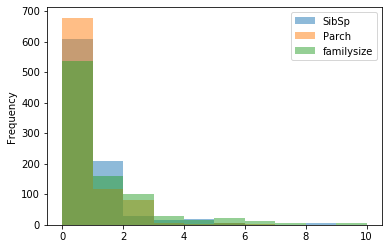

In [32]:
explore['familysize'] = explore[['SibSp','Parch']].sum(axis=1)
explore.plot.hist(alpha=0.5, bins=10)

Use pivot tables to look at the survival rate for different values of the columns:

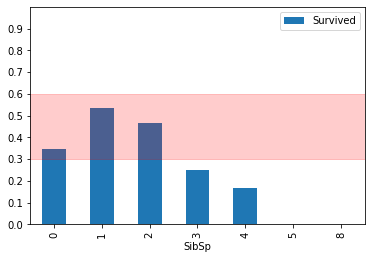

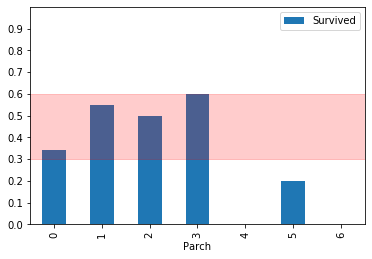

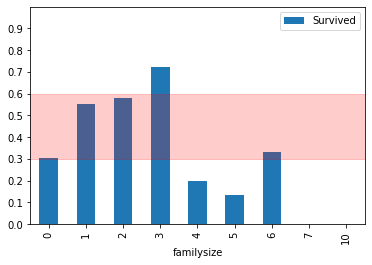

In [33]:
import numpy as np

explore_cols_all = ["SibSp","Parch","Survived"]
explore_all = train[explore_cols_all].copy()
explore_all['familysize'] = explore[['SibSp','Parch']].sum(axis=1)

for col in explore:
    pivot = explore_all.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,0.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')

We can see that both **SibSp** and **Parch** features don't have any missing value, and the survival rates are tapered off as the number of family size increases. Also, only 30% of passengers with no family member survived, which means majority of survivors had family members. Therefore, let's create a new feature in 'Feature Engineering' part.

## 2. Feature Engineering

Base on the previous analysis, adding a new feature that represent whether a passenger has familiy or not would be beneficial in training model. Hence, let's use a binary column to represent the new feature: <br>

- <font color='red'>1</font> if the passenger has zero family members onboard <br>
- <font color='red'>0</font> if the passenger has one or more family members onboard

In [34]:
def binary_filter(df):
    df['isalone'] = 0
    df.loc[((df['SibSp'] == 0) & (df['Parch'] == 0)),'isalone'] = 1
    return df

train = binary_filter(train)
holdout = binary_filter(holdout)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,0,0,0,0,0,0,1,0,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,0,0,0,0,0,0,0,1,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.5,1,2,W./C. 6607,23.4500,...,0,0,0,0,0,0,1,1,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,1,0,0,0,0,0,0,0,1,1


## 3. Feature Selection

In [35]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print('Best Columns \n' + '-'*12 + '\n{}\n'.format(best_columns)) 
    return best_columns

In [36]:
cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



## 4. Model Selection and Tuning

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    

    dic_knn = {'model_name': 'KNeighborsClassifier',
               'estimator': KNeighborsClassifier(),
               'hyperparameters':
               {
                   'n_neighbors': range(1,20,2),
                   'weights': ['distance','uniform'],
                   'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                   'p': [1,2]
               }
              }
    dic_lr = {'model_name': 'LogisticRegression',
              'estimator': LogisticRegression(),
              'hyperparameters':
              {
                  'solver': ['newton-cg','lbfgs','liblinear'] 
              }
             }
    dic_rf = {'model_name': 'RandomForestClassifier',
              'estimator': RandomForestClassifier(random_state=1),
              'hyperparameters':
              {
                  'n_estimators': [4,6,9],
                  'criterion': ['entropy','gini'],
                  'max_depth': [2,5,10],
                  'max_features': ['log2','sqrt'],
                  'min_samples_leaf': [1,5,8],
                  'min_samples_split':[2,3,5]
              }
             }
    
    models = [dic_knn, dic_lr, dic_rf]

    for md in models:
        print(md['model_name'])
        print('-'*len(md['model_name']))
        grid = GridSearchCV(md['estimator'], 
                            param_grid=md['hyperparameters'],
                            cv=10)
        grid.fit(all_X, all_y)
              
        md['best_score'] = grid.best_score_
        md['best_params'] = grid.best_params_
        md['best_model'] = grid.best_estimator_
        
        print('Best Parameters: {}.'.format(md['best_params']))
        print('Best Scores: {}\n'.format(md['best_score']))
        
    return models

result = select_model(train, cols)


KNeighborsClassifier
--------------------
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}.
Best Scores: 0.7755331088664422

LogisticRegression
------------------
Best Parameters: {'solver': 'liblinear'}.
Best Scores: 0.8204264870931538

RandomForestClassifier
----------------------
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}.
Best Scores: 0.8294051627384961



## 5. Final Result Submission

In [38]:
def save_submission_file(model, cols, filename='submission.csv'):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    submission_dic = {'PassengerId': holdout['PassengerId'],
                      'Survived': predictions}
    submission = pd.DataFrame(submission_dic)
    submission.to_csv(r'D:\Documents\Python-Dataquest\Guided Project_Titanic_Workflow\submission.csv',index=False)

We can see that, so far, the random forest model has the best result. Hence, let's use this model for now.

In [39]:
best_rf_model = result[2]['best_model']
save_submission_file(best_rf_model, cols)

The Final result of the Kaggle score is 0.77990.

## 6. Conclusion

In this project, four main steps were implemented: 

- Data exploration
- Feature engineering
- Feature selection
- Model selection and tuning

In data exploration, we looked into each feature to better understand the correlations and importance to the target feature (**'Survived'**). In feature engineering, a new feature(**'isalone'**) was introduced. In feature selection, we used the built in function RFECV to select the best features. In model selection and tuning, three different models (KNeighborsClassifier, LogisticRegression, RandomForestClassifier) were compared, and GridSearch method was used to select the best parameters as well as evaluate the best-score model.

Given only one new feature (**'isalone'**) was created, we get the conclusion that random forest model has the best performance. To get a better result, we can go back to feature engineering process to creat new features that might be beneficial to model training.